In [2]:
import xarray as xr
from saveCore_standalone_NFLICS import run_powerBlobs, powerBlob_utils, util
import ccores.cores as cores
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import os
from utils import u_darrays as uda
from eod import msg_panAfrica
from utils import u_grid, u_interpolate as u_int
import glob
from utils import constants as cnst

In [1]:
cd ..

/home/ck/pythonWorkspace/proj_CEH


In [3]:
met_folder = cnst.ext_drive+'NFLICS/'
files = glob.glob(met_folder + 'IR_108_BT_20200905_2300.nc')

ds = xr.open_dataset(files[0], decode_times=False).squeeze()

In [4]:
ds

<xarray.Dataset>
Dimensions:   (x: 772, y: 580)
Coordinates:
    time      float64 0.0
  * x         (x) int32 0 1 2 3 4 5 6 7 8 ... 764 765 766 767 768 769 770 771
  * y         (y) int32 0 1 2 3 4 5 6 7 8 ... 572 573 574 575 576 577 578 579
Data variables:
    IR108_BT  (x, y) float32 ...
    lat_2d    (x, y) float32 ...
    lon_2d    (x, y) float32 ...
Attributes:
    description:  SEVIRI 10.8 micron BT extracted from EUMETSAT HRIT files
    history:      Created 20200906
    source:       EUMETSAT SEVIRI HRIT

In [5]:
## a clean way of plotting - use matplotlib functions directly:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
def draw_map(ax, data, lon, lat, title=None,  mask_sig=None, quiver=None, contour=None, cbar_label=None, **kwargs):

    mapp = ax.contourf(lon, lat, data, transform=ccrs.PlateCarree(), **kwargs)  # this is the actual plot
    
    ## mask for significance indicator
    if mask_sig is not None:
         plt.contourf(lon, lat, mask_sig, colors='none', hatches='.',
                     levels=[0.5, 1], linewidth=0.1)
    
    ## quiver list
    if quiver is not None:
        qu = ax.quiver(quiver['x'], quiver['y'], quiver['u'], quiver['v'], scale=quiver['scale'])
    ## additional contour on plot   
    if contour is not None:
        ax.contour(contour['x'], contour['y'], contour['data'], levels=contour['levels'], cmap=contour['cmap'] )
        
    
    ax.coastlines()   ## adds coastlines
    # Gridlines
    xl = ax.gridlines(draw_labels=True);   # adds latlon grid lines
    xl.xlabels_top = False   ## labels off
    xl.ylabels_right = False
    plt.title(title)
    # Countries
    ax.add_feature(cartopy.feature.BORDERS, linestyle='--'); # adds country borders
    cbar = plt.colorbar(mapp)  # adds colorbar
    cbar.set_label(cbar_label)

/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/ck/miniconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


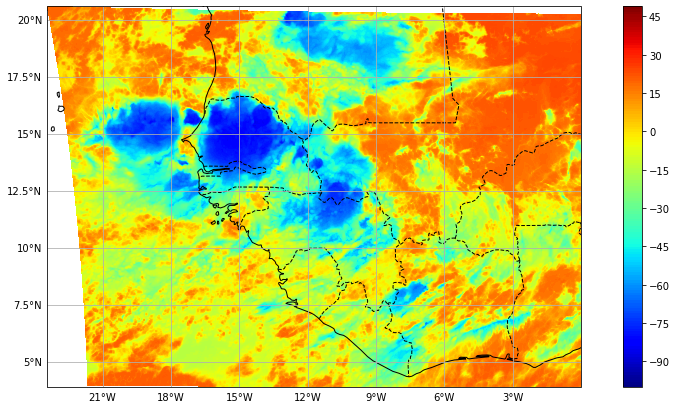

In [6]:
f=plt.figure(figsize=(15,7))  # this opens a plot window
ax = f.add_subplot(111, projection=ccrs.PlateCarree())  # this opens a new plot axis
draw_map(ax, ds['IR108_BT'].values, ds.lon_2d, ds.lat_2d, levels=np.arange(-100,50), cmap='jet')

In [7]:
%%time
wObj = cores.dataset('METEOSAT3K_test')
wObj.read_img(ds['IR108_BT'].values, ds.lon_2d.values, ds.lat_2d.values, edge_smoothing=False)
wObj.applyWavelet(normed='scale')
current_nflics = wObj.scaleWeighting(wtype='nflics3k')
new_nflics = wObj.scaleWeighting(wtype='nflics')

Initialised wavelet with scales:  [  9.          12.552693    17.50778905  24.41887789  34.05807528
  47.50228479  66.25351084  92.40666462 128.88361021 179.75959904]
Please provide regular grid coordinates.
outmin -87.42082 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 177.2736920368411
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting
CPU times: user 2.19 s, sys: 139 ms, total: 2.33 s
Wall time: 2.33 s


In [8]:
%%time
wObj = cores.dataset('METEOSAT3K_veraLS')
wObj.read_img(ds['IR108_BT'].values, ds.lon_2d.values, ds.lat_2d.values, edge_smoothing=False)
wObj.applyWavelet(normed='scale')
current_nflics_std = wObj.scaleWeighting(wtype='nflics3k')
new_nflics_std = wObj.scaleWeighting(wtype='nflics')

Initialised wavelet with scales:  [ 12.          18.1885988   27.56876052  41.78642704  63.33637972
  96.         145.50879038]
Please provide regular grid coordinates.
outmin -87.42082 0.0
Wavelet coefficients and power normed by: scale Possible tags: "scale", "stddev"
power threshold 86.20994625645575
Assuming Meteosat MSG dataset. If incorrect, please set explicit data_tag keyword for .scaleWeighting
CPU times: user 1.59 s, sys: 111 ms, total: 1.7 s
Wall time: 1.69 s


Text(0.5, 1.0, 'New, stddev normalisation')

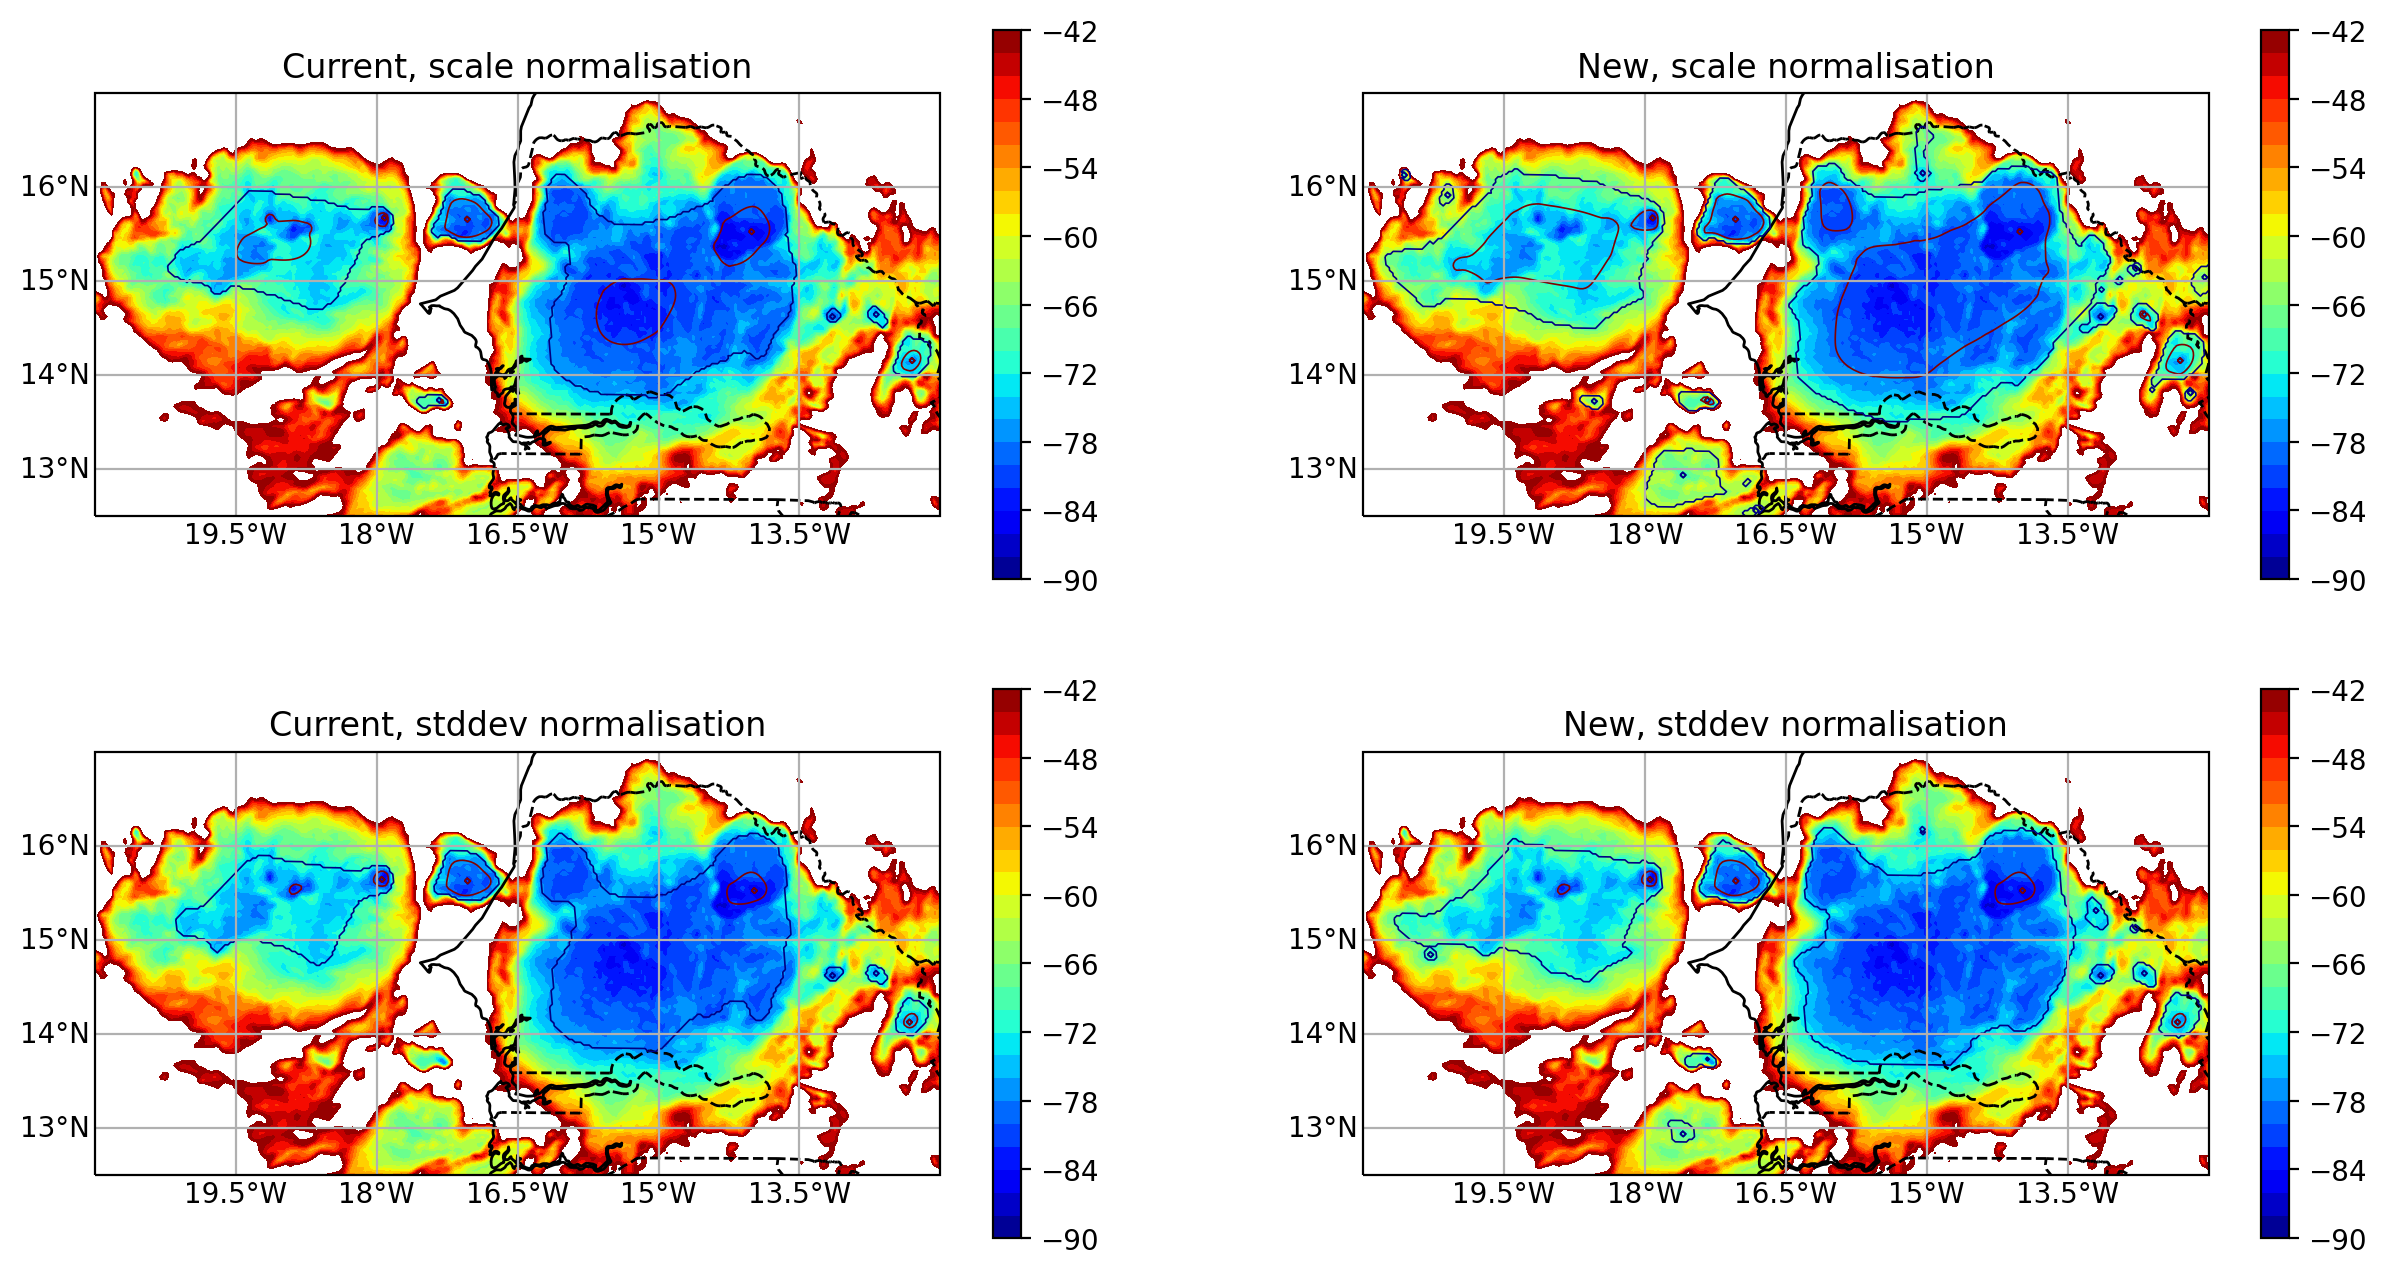

In [23]:
box = [-21,-12,12.5,17]
f = plt.figure(figsize=(15,8), dpi=200)
ax = f.add_subplot(221, projection=ccrs.PlateCarree())
draw_map(ax, wObj.original, ds.lon_2d, ds.lat_2d, cmap='jet', levels=np.arange(-90,-40,2))
ax.contour(ds.lon_2d, ds.lat_2d,  current_nflics, levels=[-1,0,350], cmap='jet', linewidths=0.6)
ax.set_ylim(box[2], box[3])
ax.set_xlim(box[0],box[1])
ax.set_title('Current, scale normalisation')

ax = f.add_subplot(222, projection=ccrs.PlateCarree())
draw_map(ax, wObj.original, ds.lon_2d, ds.lat_2d, cmap='jet', levels=np.arange(-90,-40,2))
ax.contour(ds.lon_2d, ds.lat_2d,  new_nflics, levels=[-1,0,250], cmap='jet', linewidths=0.6)
ax.set_ylim(box[2], box[3])
ax.set_xlim(box[0],box[1])
ax.set_title('New, scale normalisation')

ax = f.add_subplot(223, projection=ccrs.PlateCarree())
draw_map(ax, wObj.original, ds.lon_2d, ds.lat_2d, cmap='jet', levels=np.arange(-90,-40,2))
ax.contour(ds.lon_2d, ds.lat_2d,  current_nflics_std, levels=[-1,0,200], cmap='jet', linewidths=0.6)
ax.set_ylim(box[2], box[3])
ax.set_xlim(box[0],box[1])
ax.set_title('Current, stddev normalisation')

ax = f.add_subplot(224, projection=ccrs.PlateCarree())
draw_map(ax, wObj.original, ds.lon_2d, ds.lat_2d, cmap='jet', levels=np.arange(-90,-40,2))
ax.contour(ds.lon_2d, ds.lat_2d,  new_nflics_std, levels=[-1,0,200], cmap='jet', linewidths=0.6)
ax.set_ylim(box[2], box[3])
ax.set_xlim(box[0],box[1])
ax.set_title('New, stddev normalisation')

In [10]:
prcp = xr.open_dataset(glob.glob('/media/ck/LStorage/NFLICS/GPM/2020/09/3B-HHR.MS.MRG.3IMERG.20200905*.1380.V06B*')[0])  #, group='/Grid/'
prcp = prcp['precipitationCal'].squeeze()
#prcp = prcp['IRprecipitation'].squeeze()
# pbox = prcp.sel(lat=slice(np.min(latitudes), np.max(latitudes)), lon=slice(np.min(longitudes),np.max(longitudes)))
prcp = prcp.sel(lon=slice(-25,0), lat=slice(8,20))

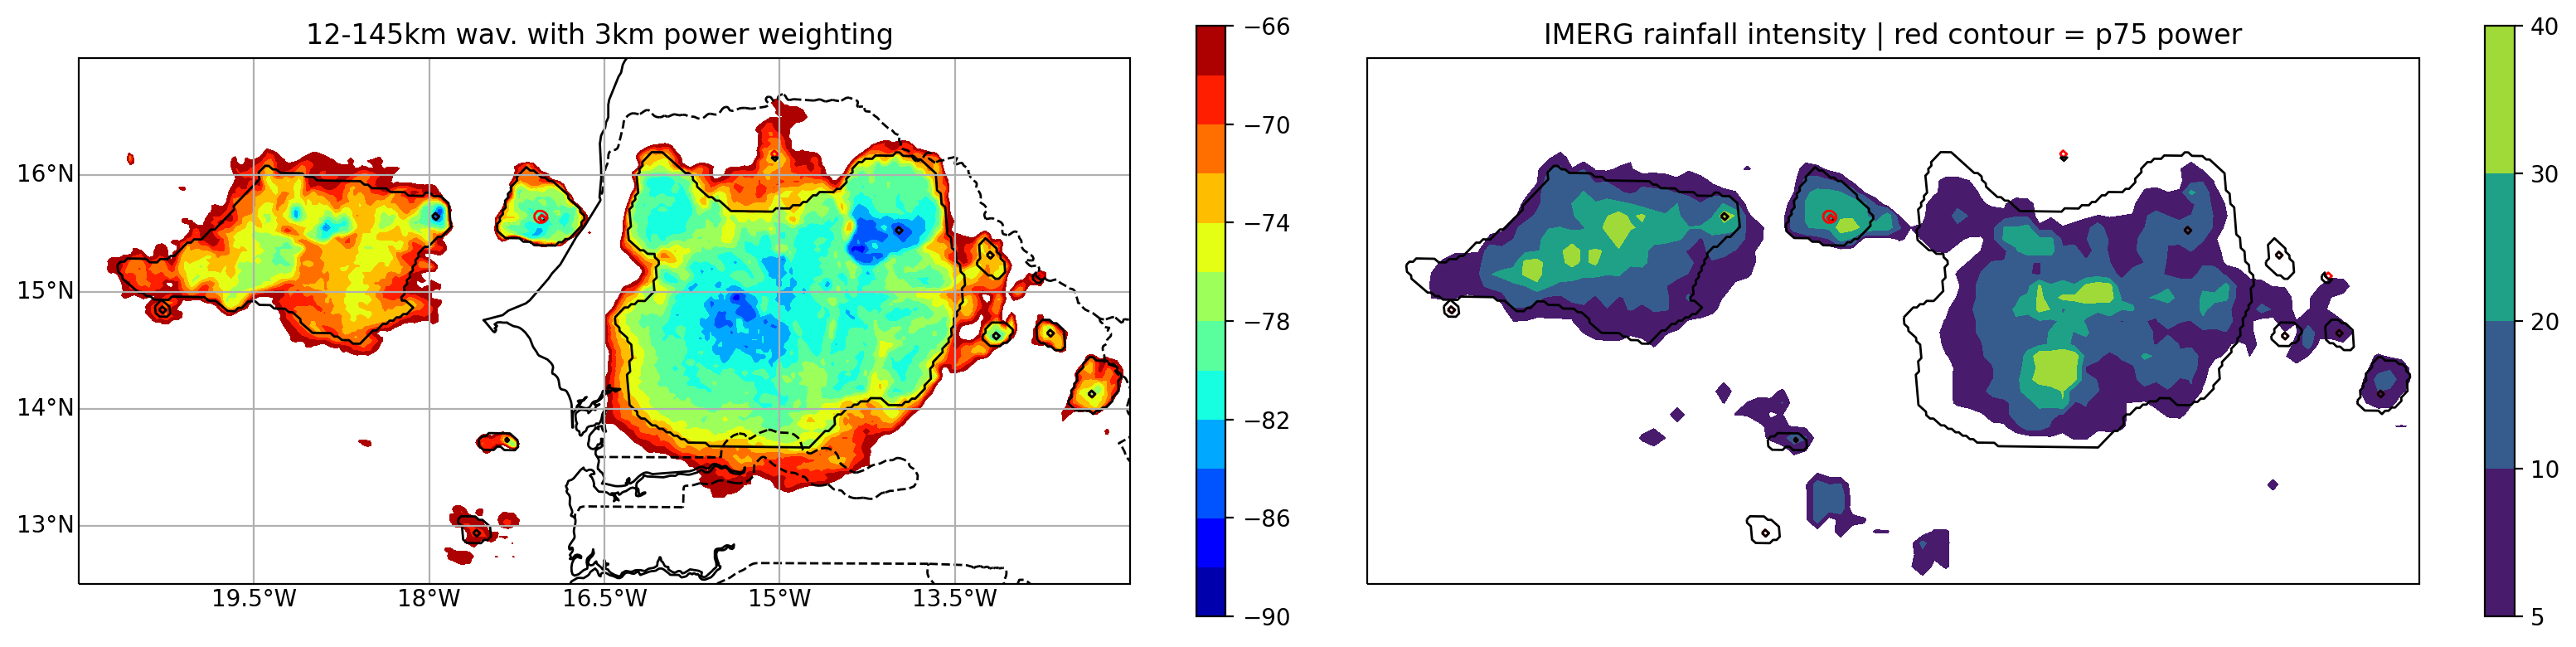

In [26]:
f = plt.figure(figsize=(16,4), dpi=200)
ax = f.add_subplot(121, projection=ccrs.PlateCarree())
ax.set_ylim(box[2], box[3])
ax.set_xlim(box[0],box[1])
draw_map(ax, wObj.original, ds.lon_2d, ds.lat_2d, cmap='jet', levels=np.arange(-90,-65,2))
ax.contour(ds.lon_2d, ds.lat_2d,  new_nflics_std, levels=[-1,0,350], colors=['red','k'], linewidths=1)
ax.set_ylim(box[2], box[3])
ax.set_xlim(box[0],box[1])
ax.set_title('12-145km wav. with 3km power weighting ')


ax = f.add_subplot(122, projection=ccrs.PlateCarree())
ax.set_ylim(box[2], box[3])
ax.set_xlim(box[0],box[1])
ax.set_title('IMERG rainfall intensity | red contour = p75 power')
plt.contourf(prcp.lon, prcp.lat, prcp.T, cmap='viridis', linewidths=0.6, levels=[5,10,20,30,40])
plt.colorbar()
ax.contour(ds.lon_2d, ds.lat_2d,  new_nflics_std, levels=[-1,0,350], colors=['red','k'], linewidths=1)
plt.tight_layout()
#f.savefig("/home/ck/DIR/cornkle/data/nflics/core_tests/core_visualisation_example_3kpower.jpg")